In [1]:
%%time
%matplotlib inline
from new_import import *

CPU times: user 13.2 s, sys: 4.09 s, total: 17.3 s
Wall time: 10.9 s


In [2]:
%%time
# Cấu hình Daskgateway
cluster, client = notebook_utils.initialize_dask(use_gateway=True, workers=(1,10))
# Khai báo 1 Datacube là dc
dc = datacube.Datacube()

client

Starting new cluster.
CPU times: user 895 ms, sys: 114 ms, total: 1.01 s
Wall time: 3min 43s


Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: https://hub.asia.easi-eo.solutions/services/dask-gateway/clusters/easihub.4a865986e290409ea32f210c2f313926/status,


In [3]:
# Cấu hình truy cập dịch vụ S3
configure_s3_access(aws_unsigned=False, requester_pays=True, client=client)

In [4]:
## cấu hình thời gian lấy ảnh và tọa độ
date_range = ('2022-09-01', '2023-10-01')
longtitude_range = (105.5, 106.4)
latitude_range = (9.2, 10.0) 

In [74]:
## truy vấn ảnh vệ tinh sen2
data_sen2 = load_data(dc, date_range, longtitude_range, latitude_range)
notebook_utils.heading(notebook_utils.xarray_object_size(data_sen2))

Most common native CRS: EPSG:32648
No datasets require offset correction
The valid_data_mask and scale (no offset) have been applied to the reflectance bands


In [96]:
data_sen2

<xarray.Dataset>
Dimensions:      (time: 151, y: 8874, x: 9902)
Coordinates:
  * time         (time) datetime64[ns] 2022-09-02T03:35:23.960000 ... 2023-09...
  * y            (y) float64 1.106e+06 1.106e+06 ... 1.017e+06 1.017e+06
  * x            (x) float64 5.548e+05 5.548e+05 ... 6.538e+05 6.538e+05
    spatial_ref  int32 32648
Data variables:
    red          (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    scl          (time, y, x) uint8 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
Attributes:
    crs:           EPSG:32648
    grid_mapping:  spatial_ref

In [85]:
data_sen2.isel(time=6).to_array()

<xarray.DataArray (variable: 3, y: 8874, x: 9902)>
dask.array<stack, shape=(3, 8874, 9902), dtype=float32, chunksize=(1, 2048, 2048), chunktype=numpy.ndarray>
Coordinates:
    time         datetime64[ns] 2022-09-17T03:35:13.648000
  * y            (y) float64 1.106e+06 1.106e+06 ... 1.017e+06 1.017e+06
  * x            (x) float64 5.548e+05 5.548e+05 ... 6.538e+05 6.538e+05
    spatial_ref  int32 32648
  * variable     (variable) object 'red' 'nir' 'scl'
Attributes:
    crs:           EPSG:32648
    grid_mapping:  spatial_ref

In [ ]:
plt.imshow(data_sen2.isel(time=6).to_array())

In [7]:
%%time
# Tiến hành loại bỏ các vị trí bị mây ảnh hưởng
result = mask_clean(data_sen2)
progress(result)

,bits,values,description
qa,"[0, 1, 2, 3, 4, 5, 6, 7]","{'0': 'no data', '1': 'saturated or defective'...",Sen2Cor Scene Classification


{'0': 'no data',
 '1': 'saturated or defective',
 '2': 'dark area pixels',
 '3': 'cloud shadows',
 '4': 'vegetation',
 '5': 'bare soils',
 '6': 'water',
 '7': 'unclassified',
 '8': 'cloud medium probability',
 '9': 'cloud high probability',
 '10': 'thin cirrus',
 '11': 'snow or ice'}

CPU times: user 1.49 s, sys: 39.3 ms, total: 1.53 s
Wall time: 1.52 s


VBox()

In [91]:
datasets_sen1 = dc.find_datasets(
    product="sentinel1_grd_gamma0_20m",
    x=(105.5, 106.4),
    y=(9.2, 10.0),
    time=('2022-09-01', '2023-10-01')
)

In [ ]:
datasets_sen1

In [97]:
data_sen1 = dc.load(
    product="sentinel1_grd_gamma0_20m",
    x=(105.5, 106.4),
    y=(9.2, 10.0),
    time=('2022-09-01', '2023-10-01'),
    measurements=["vv", "vh"],
    output_crs="EPSG:32648",
    resolution=(-10,10),
    dask_chunks={"x":2048, "y":2048},
    skip_broken_datasets=True,
    group_by='solar_day'
)

In [98]:
data_sen1

<xarray.Dataset>
Dimensions:      (time: 119, y: 8874, x: 9902)
Coordinates:
  * time         (time) datetime64[ns] 2022-09-06T22:46:14.500000 ... 2023-09...
  * y            (y) float64 1.106e+06 1.106e+06 ... 1.017e+06 1.017e+06
  * x            (x) float64 5.548e+05 5.548e+05 ... 6.538e+05 6.538e+05
    spatial_ref  int32 32648
Data variables:
    vv           (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    vh           (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
Attributes:
    crs:           EPSG:32648
    grid_mapping:  spatial_ref

In [40]:
data_sen1['vh']

<xarray.DataArray 'vh' (time: 33, y: 8874, x: 9902)>
dask.array<dc_load_vh, shape=(33, 8874, 9902), dtype=float32, chunksize=(1, 2048, 2048), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2022-09-06T22:46:14.500000 ... 2023-09...
  * y            (y) float64 1.106e+06 1.106e+06 ... 1.017e+06 1.017e+06
  * x            (x) float64 5.548e+05 5.548e+05 ... 6.538e+05 6.538e+05
    spatial_ref  int32 32648
Attributes:
    units:         intensity
    nodata:        nan
    crs:           EPSG:32648
    grid_mapping:  spatial_ref

In [41]:
data_sen1['vv']

<xarray.DataArray 'vv' (time: 33, y: 8874, x: 9902)>
dask.array<dc_load_vv, shape=(33, 8874, 9902), dtype=float32, chunksize=(1, 2048, 2048), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2022-09-06T22:46:14.500000 ... 2023-09...
  * y            (y) float64 1.106e+06 1.106e+06 ... 1.017e+06 1.017e+06
  * x            (x) float64 5.548e+05 5.548e+05 ... 6.538e+05 6.538e+05
    spatial_ref  int32 32648
Attributes:
    units:         intensity
    nodata:        nan
    crs:           EPSG:32648
    grid_mapping:  spatial_ref

In [49]:
print(data_sen1['vh'][1][0][0])

<xarray.DataArray 'vh' ()>
dask.array<getitem, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    time         datetime64[ns] 2022-09-18T22:46:13.500000
    y            float64 1.106e+06
    x            float64 5.548e+05
    spatial_ref  int32 32648
Attributes:
    units:         intensity
    nodata:        nan
    crs:           EPSG:32648
    grid_mapping:  spatial_ref


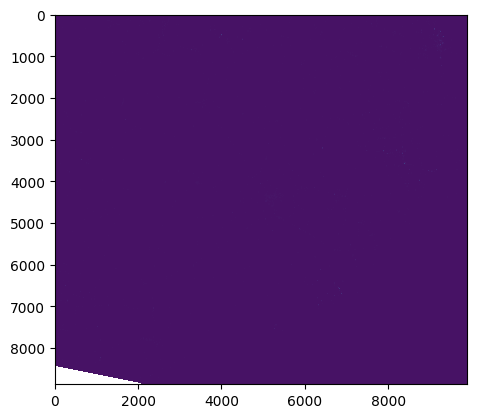

In [106]:
vv_data = data_sen1['vv'].isel(time=32)
plt.imshow(vv_data, cmap='viridis', vmin=-10, vmax=200)
plt.show()

In [60]:
print(vv_data)

<xarray.DataArray 'vv' (y: 8874, x: 9902)>
dask.array<where, shape=(8874, 9902), dtype=float32, chunksize=(2048, 2048), chunktype=numpy.ndarray>
Coordinates:
    time         datetime64[ns] 2023-09-25T22:46:19.500000
  * y            (y) float64 1.106e+06 1.106e+06 ... 1.017e+06 1.017e+06
  * x            (x) float64 5.548e+05 5.548e+05 ... 6.538e+05 6.538e+05
    spatial_ref  int32 32648
Attributes:
    units:         intensity
    nodata:        nan
    crs:           EPSG:32648
    grid_mapping:  spatial_ref


In [107]:
print(data_sen1['vv'].min().values)

-160.52818


In [109]:
from deafrica_tools.bandindices import dualpol_indices
new_data_sen1 = dualpol_indices(ds=data_sen1, index="RVI")

In [110]:
print(new_data_sen1['RVI'].min().values)
print(new_data_sen1['RVI'].max().values)

-362247.56
130512.24


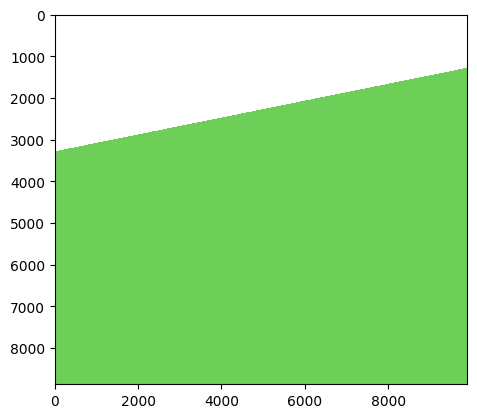

In [114]:
plt.imshow(new_data_sen1['RVI'].isel(time=2))

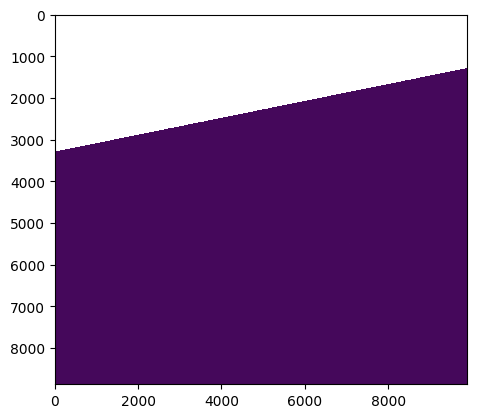

In [117]:
plt.imshow(new_data_sen1['RVI'].isel(time=6))